### WEB SCRAPPING
This notebook contains a web scraping pipeline designed to extract hotel data from the Booking.com website efficiently.

Motivation & Initial Approach
In our initial implementation, we used a single browser instance to scrape hotel listings for two cities across two different weeks, resulting in the creation of four CSV files. However, this sequential approach proved to be time-consuming, significantly increasing the execution time.

Optimized Approach: Parallel Execution
To enhance efficiency, we implemented parallel execution, leveraging four separate browser instances to scrape data simultaneously. This optimization dramatically reduces the overall runtime while maintaining accuracy and reliability.

### PIPELINE:


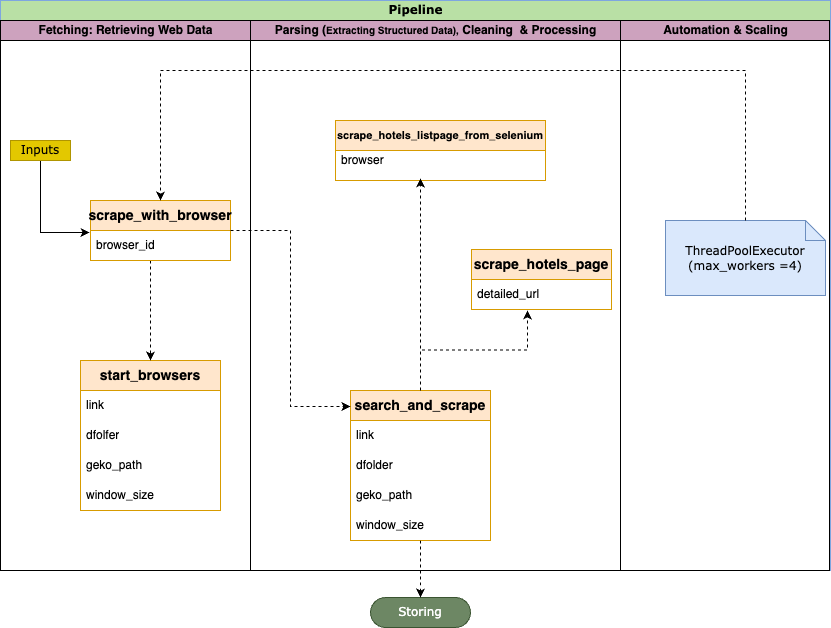

In [14]:
from IPython.display import Image, display

display(Image("pipeline.png"))

#For better view expand image.

### SCRIPT

In [ ]:
#First Import the used libraries.
from concurrent.futures import ThreadPoolExecutor  
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import re

"""
This script integrates five distinct functions, each contributing to a coherent and efficient web scraping pipeline. It begins by sending a request to the Booking.com website, initializing a Firefox WebDriver, and configuring browser preferences. It then automates the process of navigating through the site, handling pop-ups, and dynamically interacting with page elements.

Once the necessary data is extracted, it is cleaned, formatted, and structured appropriately before being stored in four CSV files. The implementation of parallel execution enhances performance, making the scraper both robust and efficient, capable of handling large-scale data collection with ease.
"""





# Function to Start Firefox Browser
def start_browser(link, dfolder, geko_path, window_size='1500,1080'):
    os.makedirs(dfolder, exist_ok=True)
    options = Options()
    options.add_argument('--start-maximized')
    options.set_preference('privacy.trackingprotection.enabled', True)  #This Code is to avoid cookies
    service = Service(geko_path)
    browser = webdriver.Firefox(service=service, options=options)
    
    width, height = map(int, window_size.split(','))
    browser.set_window_size(width, height)
    
    browser.get(link)
    time.sleep(5)  # Let page load
    return browser

"""
 This function launches a Firefox WebDriver and navigates to the target URL. We added the privacy.trackingprotection.enabled setting to prevent tracking cookies from appearing later on the website.
Once the link is accessed and the webpage is opened, we wait for a few seconds to allow any potential pop-ups to load before proceeding.
And we fixed a window_size to improve the visibility and consistency, because in the previous coded that we had, the size of the window was not consistent.
"""





# Function to Search, Scroll & Scrape Hotels
def search_and_scrape(browser, city, year, month, month_text, arrival_day, departure_day, filename):
    try:
        print(f"Searching for {city} ({year}-{month}-{arrival_day} to {year}-{month}-{departure_day})")
        
        def close_genius():
            try:
                
                close_button_xpath = '//div[@class="abcc616ec7 cc1b961f14 c180176d40 f11eccb5e8 ff74db973c"]'
                
                # Wait for the element to be clickable.
                close_button = WebDriverWait(browser, 10).until(
                    EC.element_to_be_clickable((By.XPATH, close_button_xpath))
                )
                try:
                    close_button.click()
                except Exception as click_error:
                    # If the normal click fails, try a JavaScript click
                    browser.execute_script("arguments[0].click();", close_button)
                
                print(f"Closing Genius Banner for {city} - {filename}")
            except Exception as e:
                print(f"No Genius Banner for {city}, {filename}")

        close_genius()

        # Click search bar and enter city
        time.sleep(5)
        browser.find_element(by=By.XPATH,value='//*[@id=":rh:"]').click()
        time.sleep(1)
        search_box = WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id=":rh:"]')))
        search_box.send_keys(city)
        time.sleep(1)
        browser.find_element(By.XPATH, '//*[@class="ebbedaf8ac ab26a5d2bd e33c97ff6b"]').click()
        time.sleep(2)

        # Select correct month and year
        target_date = month_text + ' ' + year
        while browser.find_element(By.XPATH, '//h3[contains(@class, "e1eebb6a1e ee7ec6b631")]').text.strip() != target_date:
            browser.find_element(By.XPATH, '//*[@class="a83ed08757 c21c56c305 f38b6daa18 d691166b09 f671049264 f4552b6561 dc72a8413c f073249358"]').click()
            time.sleep(1)

        # Select arrival and departure dates
        dates = browser.find_elements(By.XPATH, '//table[@class="eb03f3f27f"]//td[@class="b80d5adb18"]//span[@class="cf06f772fa ef091eb985"]')
        for date in dates:
            if date.get_attribute("data-date") == f"{year}-{month}-{arrival_day}":
                date.click()
            if date.get_attribute("data-date") == f"{year}-{month}-{departure_day}":
                date.click()
                break
        time.sleep(2)

        # Click search button
        browser.find_element(By.XPATH, '//button[@class="a83ed08757 c21c56c305 a4c1805887 f671049264 a2abacf76b c082d89982 cceeb8986b b9fd3c6b3c"]').click()
        time.sleep(2)

        # Close Genius pop-up again if it appears after clicking search
        close_genius()
        print(f"Scrolling and clicking 'See More' for {city}...")
        click_count = 0
        while True:
            try:
                browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(3)

                load_more_button = WebDriverWait(browser, 15).until(
                    EC.element_to_be_clickable((By.XPATH, '//button[contains(@class,"bf0537ecb5")]'))
                )
                browser.execute_script("arguments[0].scrollIntoView({block: 'center'});", load_more_button)
                time.sleep(2)
                try:
                    load_more_button.click()
                except Exception:
                    browser.execute_script("arguments[0].click();", load_more_button)
                
                click_count += 1
                WebDriverWait(browser, 15).until(
                    lambda b: len(b.find_elements(By.XPATH, '//div[@data-testid="property-card"]')) > 0
                )
                
                time.sleep(2)
                
            except (NoSuchElementException, TimeoutException):
                break
        print(f'The "See More" button was clicked {click_count} times')

        # Scrape hotels
        print(f"Scraping hotels for {city}...")
        hotel_list_data = scrape_hotel_list_page_from_selenium(browser)

        # Extract descriptions from detail pages
        descriptions = []
        for hotel in hotel_list_data:
            if hotel[3] != "NA":
                descriptions.append(scrape_hotel_detail_page(hotel[3]))
            else:
                descriptions.append("NA")
        
        # Build DataFrame with all columns and add descriptions
        if hotel_list_data:
            df = pd.DataFrame(hotel_list_data, columns=['Name', 'Price', 'Rating', 'Detail Link', 'Stars', 'Center', 'Num Comments'])
            df['Description'] = descriptions
            df.to_csv(filename, index=False)
            print(f"Hotel data saved to {filename}")
        else:
            print("No hotels found.")

    except Exception as e:
        print(f"Error during search and scrape: {e}")

    finally:
        print(f"Closing browser for {city}")
        browser.quit()

""" 
This is our main function that automates the search, scrolling, and scraping of hotels for a given city and date range.

First, it handles pop-ups by closing the "Genius Banner" if it appears. Then, it interacts with the search bar to enter the city name, selects the correct month and year, and picks the specified arrival and departure dates.

The function scrolls and clicks the "See More" button, waiting for it to reappear until all hotels are loaded. It then calls scrape_hotel_list_page_from_selenium, which extracts the necessary hotel data—except for descriptions. Since the descriptions are within each hotel's link, instead of clicking each one manually, we use scrape_hotel_detail_page, which efficiently retrieves the descriptions using requests.

Finally, once all the required data is collected, the function generates a CSV file and handles missing values by replacing them with "NA". 
 """





# Function to Scrape Hotel List
def scrape_hotel_list_page_from_selenium(browser):
    soup = BeautifulSoup(browser.page_source, 'html.parser')
    
    hotel_data = []
    hotels = soup.find_all('div', {'data-testid': 'property-card'})
    
    for hotel in hotels:
        # Name extraction
        name_elem = hotel.find('div', {'data-testid': 'title'})
        name = name_elem.get_text(strip=True) if name_elem else "NA"
        
        # Price extraction
        price_elem = hotel.find('span', {'class': 'f6431b446c fbfd7c1165 e84eb96b1f'})
        price = price_elem.get_text(strip=True) if price_elem else "NA"
        
        # Rating extraction
        rating_container = hotel.find('div', {'data-testid': 'review-score'})
        rating = rating_container.find('div').get_text(strip=True) if rating_container else "NA"
        
        # Detail link extraction
        title_link = hotel.find('a', {'data-testid': 'title-link'})
        detail_link = title_link['href'] if title_link and title_link.has_attr('href') else "NA"
        
        # Stars extraction
        stars_elem = hotel.find('div', {'class': 'b3f3c831be'})
        stars = stars_elem.get('aria-label', 'NA').split()[0] if stars_elem else "NA"
        
        # Center (distance) extraction: try CSS selector first, then fallback
        center_element = hotel.select_one('span[data-testid="distance"]')
        if not center_element:
            center_element = hotel.find(lambda tag: tag.name == "span" and "km" in tag.get_text() and "centro" in tag.get_text())
        center = center_element.get_text(strip=True).replace("a ", "") if center_element else "NA"
        
        # Number of comments extraction: look for a <div> containing "comentarios"
        comments_div = hotel.find(lambda tag: tag.name == "div" and "comentarios" in tag.get_text())
        if comments_div:
            comments_text = comments_div.get_text(strip=True)
            match = re.search(r'(\d+\.?\d*) comentario?s', comments_text)
            num_comments = match.group(1) if match else "NA"
        else:
            num_comments = "NA"
        
        hotel_data.append([name, price, rating, detail_link, stars, center, num_comments])
    
    return hotel_data

""" Once we have all the hotels listed on the website, it's time to extract their data. For this, we created this function that is called within search_and_scrape.

To maximize efficiency in scraping, we use the BeautifulSoup library, which allows us to extract the required information faster than Selenium. The retrieved data is then formatted properly for the CSV file. For example, if any data is missing, we replace it with "NA", and we clean or trim certain values to ensure we only keep the necessary information.
 """



# Function to Scrape Hotel Description
def scrape_hotel_detail_page(detail_url):
    headers = {'User-Agent': 'Mozilla/5.0'}
    try:
        response = requests.get(detail_url, headers=headers, timeout=10)
        if response.status_code != 200:
            return "Failed to load page"

        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Try multiple possible description locations. This is because I had some problems obtaining the description so I made the code robust
        description = soup.find('p', {'data-testid': 'property-description'})
        if not description:
            description = soup.find('div', {'class': 'a53cbfa6de b3efd73f69'})
        if not description:
            description = soup.find('span', {'class': 'e84eb96b1f'})
        
        return description.get_text(strip=True) if description else "NA"
    
    except Exception as e:
        print(f"Error scraping details from {detail_url}: {e}")
        return "Error"
""" 
As explained earlier, this function is used to obtain the descriptions of each hotel required for the second part of the project.

One key advantage of this function is the use of Requests to fetch descriptions from the detail_url (hotel URL). Unlike Selenium, Requests is significantly faster for retrieving static content, making the process more efficient. This function was inspired by the exercise we did in class, adapting it to optimize performance while ensuring accurate data extraction. 
To ensure reliability, the function searches for the description in multiple possible HTML elements, handling variations in the website structure. If no description is found, it returns "NA". In case of an error, it prints a message and returns "Error" instead.
"""


def scrape_with_browser(browser_id):
    dfolder = './downloads'
    geko_path = ''  # Add the correct GeckoDriver path
    link = 'https://www.booking.com/index.es.html'
    
    browser = start_browser(link, dfolder, geko_path)

    locations = [
        ("Barcelona", "2025", "03", "marzo", "01", "07", "hotels_barcelona_MWC.csv"),
        ("Madrid", "2025", "03", "marzo", "01", "07", "hotels_madrid_MWC.csv"),
        ("Barcelona", "2025", "03", "marzo", "22", "28", "hotels_barcelona_after_MWC.csv"),
        ("Madrid", "2025", "03", "marzo", "22", "28", "hotels_madrid_after_MWC.csv")
    ]

    city, year, month, month_text, arrival_day, departure_day, filename = locations[browser_id]
    search_and_scrape(browser, city, year, month, month_text, arrival_day, departure_day, filename)
    
"""
The function scrape_with_browser(browser_id) is responsible for launching a Firefox WebDriver, navigating to Booking.com, and scraping hotel data for a specific city and date range.

To improve efficiency, the script runs four parallel instances, each handling a different location and time period. The ThreadPoolExecutor ensures that all four browsers operate simultaneously, significantly reducing execution time.
This approach allows us to collect hotel data for Barcelona and Madrid, both during and after MWC 2025 at the same time.
"""

if __name__ == "__main__":
    with ThreadPoolExecutor(max_workers=4) as executor:
        executor.map(scrape_with_browser, range(4))


Error during search and scrape: Message: Browsing context has been discarded
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
NoSuchWindowError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:679:5
assert.that/<@chrome://remote/content/shared/webdriver/Assert.sys.mjs:515:13
assert.open@chrome://remote/content/shared/webdriver/Assert.sys.mjs:147:4
GeckoDriver.prototype.findElement@chrome://remote/content/marionette/driver.sys.mjs:1780:15
despatch@chrome://remote/content/marionette/server.sys.mjs:318:40
execute@chrome://remote/content/marionette/server.sys.mjs:289:16
onPacket/<@chrome://remote/content/marionette/server.sys.mjs:262:20
onPacket@chrome://remote/content/marionette/server.sys.mjs:263:9
_onJSONObjectReady/<@chrome://remote/content/marionette/transport.sys.mjs:494:20

Closing browser for Madrid
Hotel data saved to hotels_madrid_MWC.csv
Closing browser for Madrid
Ho